# Lab 1 (18.10.19)

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
import seaborn as sns
%matplotlib inline 
plt.style.use('seaborn-white')

In [2]:
def scoring_rule(model):
    """
    function that returns optimal regularization parameter of ElasticNetCV
    """
    min_mse = np.min(np.mean(model.mse_path_, axis=1))
    min_mse_se = np.std(model.mse_path_, axis=1)[np.argmin(np.mean(model.mse_path_,
                                                                   axis=1))]
    criterion = min_mse + min_mse_se
    alpha_candidates = model.alphas_[model.alphas_<= criterion]
    return max(alpha_candidates)
# This function is not currently in use!!

In [3]:
nsim = 100 # No. of simulations
nobs = 100 # No. of observations in each dataset
p = 10 # No. of irrelevant regressors
beta = np.repeat([2,3,0],[1,1,p]) # Coef vector: b1=2, b2=3, b3,...,bp=0
x0 = np.repeat(2,p+2) # out-of-sample obervation (oos)

# Initializing vectors to store results
f0_ols = np.empty(nsim) 
f0_lasso = np.empty(nsim)
f0_ridge = np.empty(nsim)

for i in range(nsim):
    
    rng = np.random.RandomState(i) # reproducibility!
    
    X = rng.multivariate_normal(mean=np.repeat(0,p+2),
                                      cov=np.eye(p+2), size=nobs) # X_i~_iidN(0,1)
    
    y = X.dot(beta) + rng.standard_normal(nobs) # y = X'b + noise
    
    fitOLS = LinearRegression().fit(X,y) # OLS
    f0_ols[i] = fitOLS.predict(x0[np.newaxis,:]) # OLS prediction of oos
    
    fitLASSO = LassoCV(cv=5).fit(X,y) # Lasso with alpha by 5-fold CV
    f0_lasso[i] = fitLASSO.fit(X,y).predict(x0[np.newaxis,:]) # Lasso prediction of oos
    
    fitRidge = RidgeCV(cv=5).fit(X,y) # Ridge with alpha by 5-fold CV
    f0_ridge[i] = fitRidge.predict(x0[np.newaxis,:]) # Ridge prediction of oos

2. We will consider out-of-sample predictions at $x_0 = (2,2,...,2)$. What value of $f(x_0)$ do you expect?

We have $E[y|X] = X\beta$. Here, $\beta=(2,3,0,...,0)$ and $x_0=(2,...,2)$, so we expect $2*2+2*3 = 10$.

In [4]:
print('E[y|x_0]=', x0.dot(beta))

E[y|x_0]= 10


3. Run the code as is. Plot the distribution of predictions f (x 0 ) for the different models. What do you
observe?

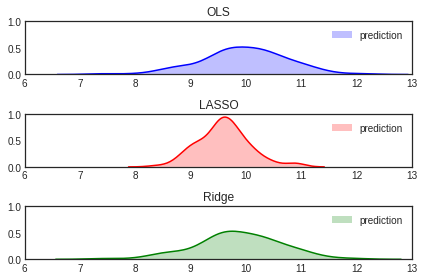

In [5]:
fig, axs = plt.subplots(3, 1, tight_layout=True) # Creating fig with 1 col, 3 rows
titles = ['OLS', 'LASSO', 'Ridge']
preds = [f0_ols, f0_lasso, f0_ridge]
colors = ['b', 'r', 'g']
for i in range(len(axs)):
    sns.kdeplot(preds[i], ax=axs[i], color=colors[i], shade=True)
    axs[i].set_title(titles[i])
    axs[i].set_ylim(0, 1)
    axs[i].set_xlim(6, 13)
    axs[i].legend(labels=['prediction'])
plt.show()

4. Compute bias, variance and mean squared error for the three different models at x 0 , our out-of-sample
observation.

In [6]:
regs = np.array([f0_ols, f0_lasso, f0_ridge])
pd.DataFrame({
    'method': ['OLS', 'LASSO', 'Ridge'],
    'bias': np.mean(regs, axis=1)-x0.dot(beta),
    'variance': np.var(regs, axis=1),
    'MSE': (x0.dot(beta) - np.mean(regs, axis=1))**2 + np.var(regs, axis=1) + 1
})

,method,bias,variance,MSE
0,OLS,-0.041666,0.600226,1.601962
1,LASSO,-0.397865,0.215359,1.373656
2,Ridge,-0.135997,0.589906,1.608401


5. How do bias and variance depend on the number of irrelevant regressors?

In [18]:
def simResults(nsim, nobs, p):
    """
    function that automizes simulations and returns summary
    """
    beta = np.repeat([2,3,0],[1,1,p]) # Coef vector: b1=2, b2=3, b3,...,bp=0
    x0 = np.repeat(2,p+2) # out-of-sample obervation (oos)

    # Initializing vectors to store results
    f0_ols = np.empty(nsim) 
    f0_lasso = np.empty(nsim)
    f0_ridge = np.empty(nsim)
    alpha_lasso = np.empty(nsim)
    alpha_ridge = np.empty(nsim)

    for i in range(nsim):

        rng = np.random.RandomState(i) # reproducibility!

        X = rng.multivariate_normal(mean=np.repeat(0,p+2),
                                          cov=np.eye(p+2), size=nobs) # X_i~_iidN(0,1)

        y = X.dot(beta) + rng.standard_normal(nobs) # y = X'b + noise

        fitOLS = LinearRegression().fit(X,y) # OLS
        f0_ols[i] = fitOLS.predict(x0[np.newaxis,:]) # OLS prediction of oos

        fitLASSO = LassoCV(cv=5).fit(X,y) # Lasso with alpha by 5-fold CV
        f0_lasso[i] = fitLASSO.fit(X,y).predict(x0[np.newaxis,:]) # Lasso prediction of oos
        alpha_lasso[i] = fitLASSO.alpha_
        
        fitRidge = RidgeCV(cv=5).fit(X,y) # Ridge with alpha by 5-fold CV
        f0_ridge[i] = fitRidge.predict(x0[np.newaxis,:]) # Ridge prediction of oos
        alpha_ridge[i] = fitRidge.alpha_
        
    summary = {
        'f0_ols': {'bias': np.mean(f0_ols)-x0.dot(beta), 'variance': np.var(f0_ols)},
        'f0_lasso': {'bias': np.mean(f0_lasso)-x0.dot(beta),
                     'variance': np.var(f0_lasso),
                    'alpha': np.mean(alpha_lasso)},
        'f0_ridge': {'bias': np.mean(f0_ridge)-x0.dot(beta),
                     'variance': np.var(f0_ridge),
                    'alpha': np.mean(alpha_ridge)}
    }
    return summary

In [ ]:
# Getting a summary dict contatining bias, variance and lambda for all sims
nIR = np.arange(0, 51, 1)
summ = {
    'f0_ols': {'bias': [], 'variance': []},
    'f0_lasso': {'bias': [], 'variance': [], 'alpha': []},
    'f0_ridge': {'bias': [], 'variance': [], 'alpha': []},
    'p': []
}
for i in nIR:
    f = simResults(100, 100, i)
    summ['f0_ols']['bias'].append(f['f0_ols']['bias'])
    summ['f0_ols']['variance'].append(f['f0_ols']['variance'])
    summ['f0_lasso']['bias'].append(f['f0_lasso']['bias'])
    summ['f0_lasso']['variance'].append(f['f0_lasso']['variance'])
    summ['f0_lasso']['alpha'].append(f['f0_lasso']['alpha'])
    summ['f0_ridge']['bias'].append(f['f0_ridge']['bias'])
    summ['f0_ridge']['variance'].append(f['f0_ridge']['variance'])
    summ['f0_ridge']['alpha'].append(f['f0_ridge']['alpha'])
    summ['p'].append(i)

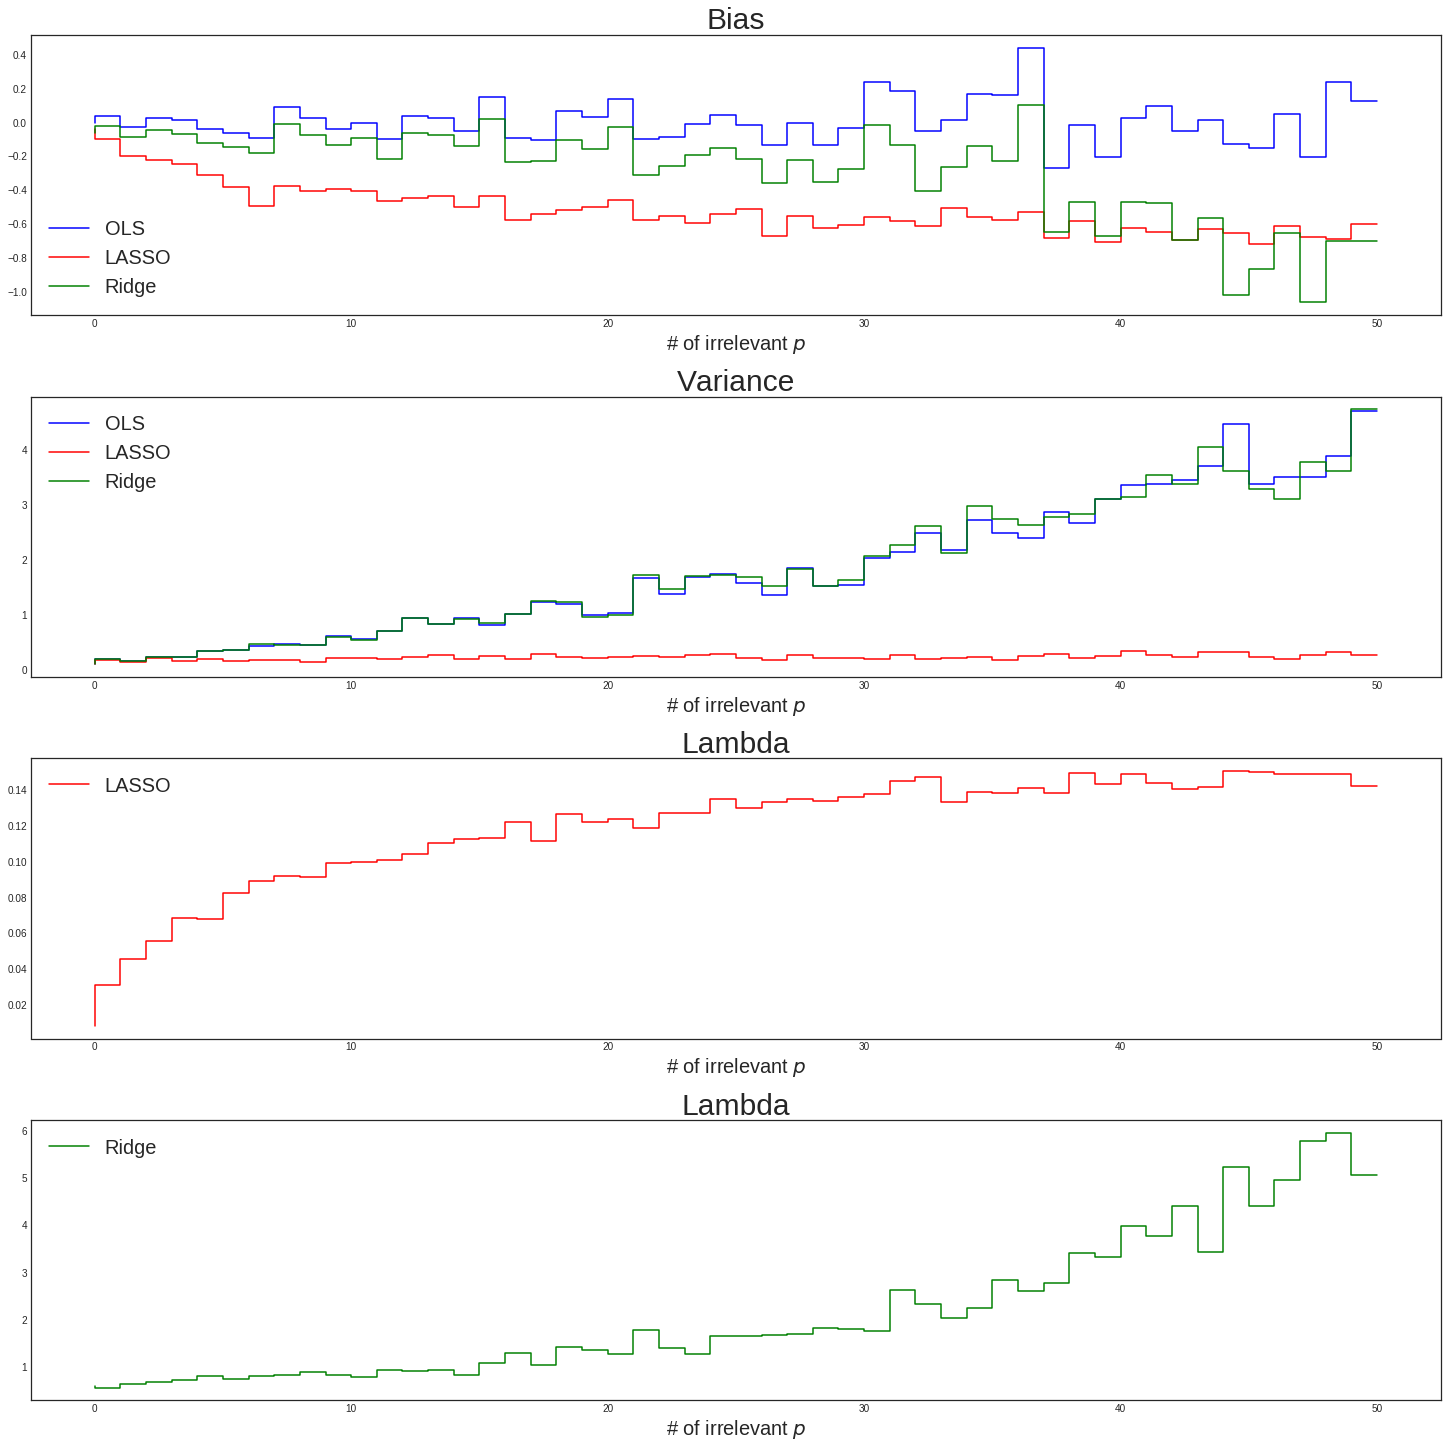

In [57]:
# Plotting bias, variance and lambda as a function of irrelevant regressors
fig, axs = plt.subplots(4, 1, figsize=(20,20), constrained_layout=True)
titles = ['OLS', 'LASSO', 'Ridge']
preds = ['f0_ols', 'f0_lasso', 'f0_ridge']
colors = ['b', 'r', 'g']

font = {'family': 'serif',
        'size': 20,
        }

axs[0].set_title('Bias', fontsize=30)
axs[0].set_xlabel('# of irrelevant $p$', fontsize=20)
axs[0].step(summ['p'], summ['f0_ols']['bias'], color='b')
axs[0].step(summ['p'], summ['f0_lasso']['bias'], color='r')
axs[0].step(summ['p'], summ['f0_ridge']['bias'], color='g')

axs[0].legend(['OLS', 'LASSO', 'Ridge'], fontsize=20)

axs[1].set_title('Variance', fontsize=30)
axs[1].set_xlabel('# of irrelevant $p$', fontsize=20)
axs[1].step(summ['p'], summ['f0_ols']['variance'], color='b')
axs[1].step(summ['p'], summ['f0_lasso']['variance'], color='r')
axs[1].step(summ['p'], summ['f0_ridge']['variance'], color='g')

axs[1].legend(['OLS', 'LASSO', 'Ridge'], fontsize=20)

axs[2].set_title('Lambda', fontsize=30)
axs[2].set_xlabel('# of irrelevant $p$', fontsize=20)
axs[2].step(summ['p'], summ['f0_lasso']['alpha'], color='r', label='LASSO')

axs[2].legend(['LASSO'], fontsize=20)

axs[3].set_title('Lambda', fontsize=30)
axs[3].set_xlabel('# of irrelevant $p$', fontsize=20)
axs[3].step(summ['p'], summ['f0_ridge']['alpha'], color='g')
axs[3].legend(['Ridge'], fontsize=20)

plt.show()

6. How do bias and variance depend on the number of observations?

In [ ]:
# Getting a summary dict contatining bias, variance and lambda for all sims
nIR = np.arange(50, 1000, 50)
summ = {
    'f0_ols': {'bias': [], 'variance': []},
    'f0_lasso': {'bias': [], 'variance': [], 'alpha': []},
    'f0_ridge': {'bias': [], 'variance': [], 'alpha': []},
    'n': []
}
for i in nIR:
    f = simResults(100, i, 10)
    summ['f0_ols']['bias'].append(f['f0_ols']['bias'])
    summ['f0_ols']['variance'].append(f['f0_ols']['variance'])
    summ['f0_lasso']['bias'].append(f['f0_lasso']['bias'])
    summ['f0_lasso']['variance'].append(f['f0_lasso']['variance'])
    summ['f0_lasso']['alpha'].append(f['f0_lasso']['alpha'])
    summ['f0_ridge']['bias'].append(f['f0_ridge']['bias'])
    summ['f0_ridge']['variance'].append(f['f0_ridge']['variance'])
    summ['f0_ridge']['alpha'].append(f['f0_ridge']['alpha'])
    summ['n'].append(i)
    print(i)

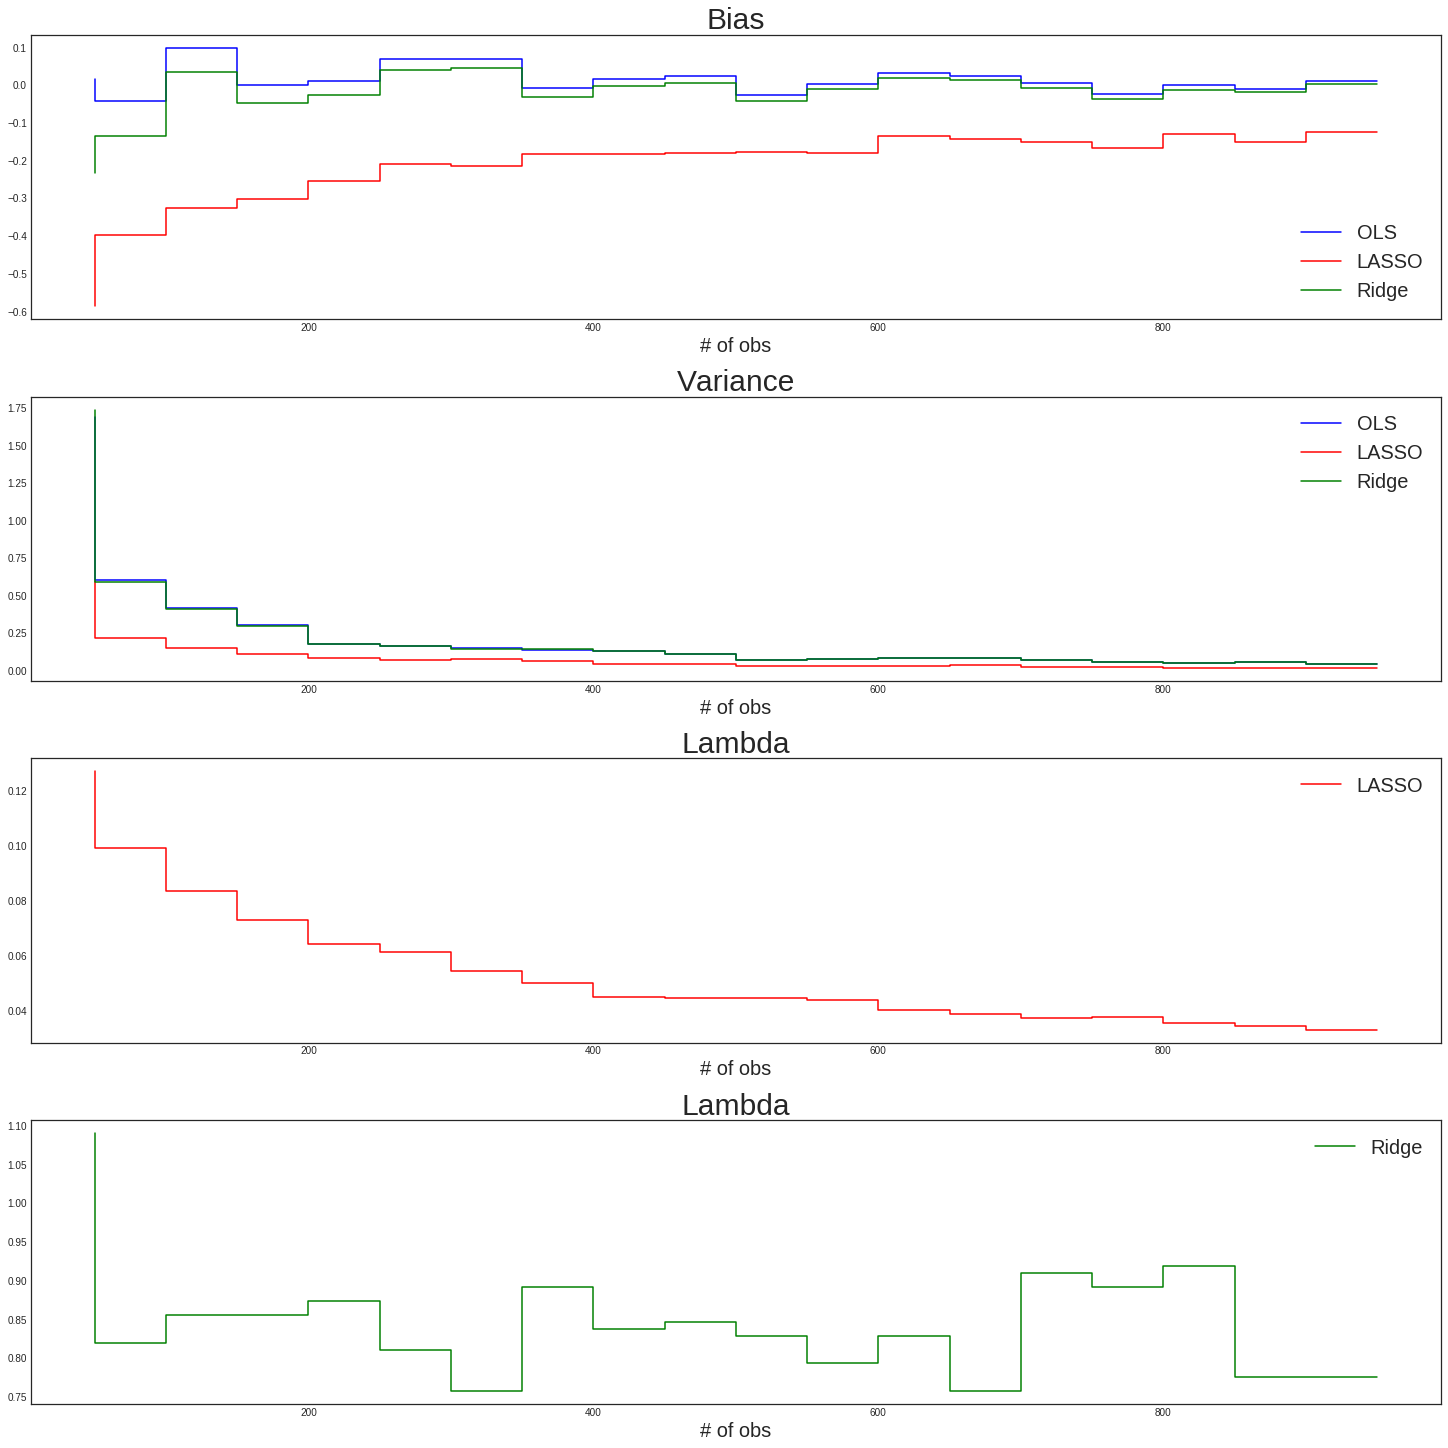

In [72]:
# Plotting bias, variance and lambda as a function of nobs
fig, axs = plt.subplots(4, 1, figsize=(20,20), constrained_layout=True) # Creating fig with 3 cols, 1 row
titles = ['OLS', 'LASSO', 'Ridge']
preds = ['f0_ols', 'f0_lasso', 'f0_ridge']
colors = ['b', 'r', 'g']

font = {'family': 'serif',
        'size': 20,
        }

axs[0].set_title('Bias', fontsize=30)
axs[0].set_xlabel('# of obs', fontsize=20)
axs[0].step(summ['n'], summ['f0_ols']['bias'], color='b')
axs[0].step(summ['n'], summ['f0_lasso']['bias'], color='r')
axs[0].step(summ['n'], summ['f0_ridge']['bias'], color='g')

axs[0].legend(['OLS', 'LASSO', 'Ridge'], fontsize=20)

axs[1].set_title('Variance', fontsize=30)
axs[1].set_xlabel('# of obs', fontsize=20)
axs[1].step(summ['n'], summ['f0_ols']['variance'], color='b')
axs[1].step(summ['n'], summ['f0_lasso']['variance'], color='r')
axs[1].step(summ['n'], summ['f0_ridge']['variance'], color='g')

axs[1].legend(['OLS', 'LASSO', 'Ridge'], fontsize=20)

axs[2].set_title('Lambda', fontsize=30)
axs[2].set_xlabel('# of obs', fontsize=20)
axs[2].step(summ['n'], summ['f0_lasso']['alpha'], color='r', label='LASSO')

axs[2].legend(['LASSO'], fontsize=20)

axs[3].set_title('Lambda', fontsize=30)
axs[3].set_xlabel('# of obs', fontsize=20)
axs[3].step(summ['n'], summ['f0_ridge']['alpha'], color='g')
axs[3].legend(['Ridge'], fontsize=20)

plt.show()

7. The simulation above assumes that regressors are uncorrelated. How do results change when
correlation between regressors is instead given by $\rho > 0$?

In [75]:
def simResults_(nsim, nobs, p, rho):
    """
    function that automizes simulations and returns summary
    """
    beta = np.repeat([2,3,0],[1,1,p]) # Coef vector: b1=2, b2=3, b3,...,bp=0
    x0 = np.repeat(2,p+2) # out-of-sample obervation (oos)

    # Initializing vectors to store results
    f0_ols = np.empty(nsim) 
    f0_lasso = np.empty(nsim)
    f0_ridge = np.empty(nsim)
    alpha_lasso = np.empty(nsim)
    alpha_ridge = np.empty(nsim)
    sigma = np.full([p+2, p+2], rho)
    np.fill_diagonal(sigma, 1)

    for i in range(nsim):

        rng = np.random.RandomState(i) # reproducibility!

        X = rng.multivariate_normal(mean=np.repeat(0,p+2),
                                          cov=sigma, size=nobs) # X_i~_iidN(0,1)

        y = X.dot(beta) + rng.standard_normal(nobs) # y = X'b + noise

        fitOLS = LinearRegression().fit(X,y) # OLS
        f0_ols[i] = fitOLS.predict(x0[np.newaxis,:]) # OLS prediction of oos

        fitLASSO = LassoCV(cv=5).fit(X,y) # Lasso with alpha by 5-fold CV
        f0_lasso[i] = fitLASSO.fit(X,y).predict(x0[np.newaxis,:]) # Lasso prediction of oos
        alpha_lasso[i] = fitLASSO.alpha_
        
        fitRidge = RidgeCV(cv=5).fit(X,y) # Ridge with alpha by 5-fold CV
        f0_ridge[i] = fitRidge.predict(x0[np.newaxis,:]) # Ridge prediction of oos
        alpha_ridge[i] = fitRidge.alpha_
        
    summary = {
        'f0_ols': {'bias': np.mean(f0_ols)-x0.dot(beta), 'variance': np.var(f0_ols)},
        'f0_lasso': {'bias': np.mean(f0_lasso)-x0.dot(beta),
                     'variance': np.var(f0_lasso),
                    'alpha': np.mean(alpha_lasso)},
        'f0_ridge': {'bias': np.mean(f0_ridge)-x0.dot(beta),
                     'variance': np.var(f0_ridge),
                    'alpha': np.mean(alpha_ridge)}
    }
    return summary

In [ ]:
# Getting a summary dict contatining bias, variance and lambda for all sims
rhos = np.arange(0, 11, 1)/10
summ = {
    'f0_ols': {'bias': [], 'variance': []},
    'f0_lasso': {'bias': [], 'variance': [], 'alpha': []},
    'f0_ridge': {'bias': [], 'variance': [], 'alpha': []},
    'rho': []
}
for rho in rhos:
    f = simResults_(100, 100, 10, rho)
    summ['f0_ols']['bias'].append(f['f0_ols']['bias'])
    summ['f0_ols']['variance'].append(f['f0_ols']['variance'])
    summ['f0_lasso']['bias'].append(f['f0_lasso']['bias'])
    summ['f0_lasso']['variance'].append(f['f0_lasso']['variance'])
    summ['f0_lasso']['alpha'].append(f['f0_lasso']['alpha'])
    summ['f0_ridge']['bias'].append(f['f0_ridge']['bias'])
    summ['f0_ridge']['variance'].append(f['f0_ridge']['variance'])
    summ['f0_ridge']['alpha'].append(f['f0_ridge']['alpha'])
    summ['rho'].append(rho)
    print(rho)

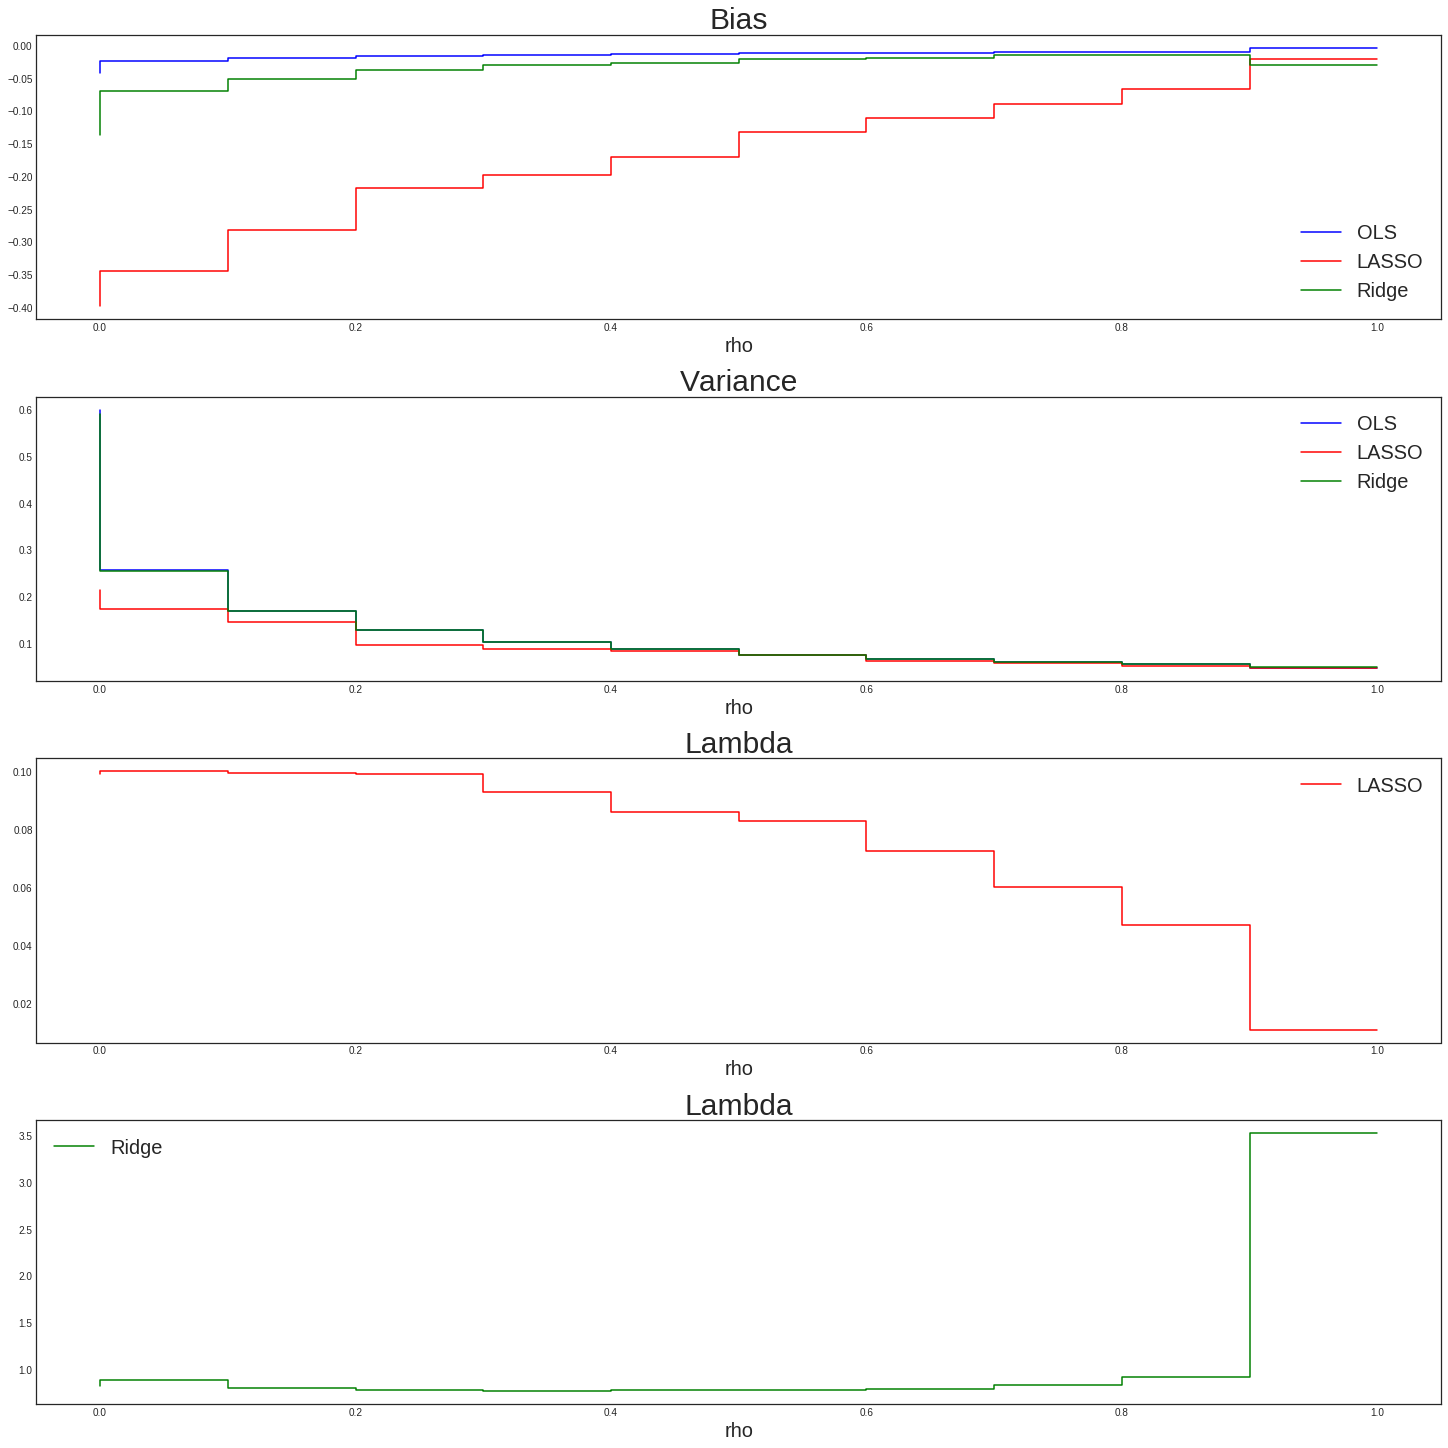

In [84]:
# Plotting bias, variance and lambda as a function of rho
fig, axs = plt.subplots(4, 1, figsize=(20,20), constrained_layout=True) # Creating fig with 3 cols, 1 row
titles = ['OLS', 'LASSO', 'Ridge']
preds = ['f0_ols', 'f0_lasso', 'f0_ridge']
colors = ['b', 'r', 'g']

font = {'family': 'serif',
        'size': 20,
        }

axs[0].set_title('Bias', fontsize=30)
axs[0].set_xlabel('rho', fontsize=20)
axs[0].step(summ['rho'], summ['f0_ols']['bias'], color='b')
axs[0].step(summ['rho'], summ['f0_lasso']['bias'], color='r')
axs[0].step(summ['rho'], summ['f0_ridge']['bias'], color='g')

axs[0].legend(['OLS', 'LASSO', 'Ridge'], fontsize=20)

axs[1].set_title('Variance', fontsize=30)
axs[1].set_xlabel('rho', fontsize=20)
axs[1].step(summ['rho'], summ['f0_ols']['variance'], color='b')
axs[1].step(summ['rho'], summ['f0_lasso']['variance'], color='r')
axs[1].step(summ['rho'], summ['f0_ridge']['variance'], color='g')

axs[1].legend(['OLS', 'LASSO', 'Ridge'], fontsize=20)

axs[2].set_title('Lambda', fontsize=30)
axs[2].set_xlabel('rho', fontsize=20)
axs[2].step(summ['rho'], summ['f0_lasso']['alpha'], color='r', label='LASSO')

axs[2].legend(['LASSO'], fontsize=20)

axs[3].set_title('Lambda', fontsize=30)
axs[3].set_xlabel('rho', fontsize=20)
axs[3].step(summ['rho'], summ['f0_ridge']['alpha'], color='g')
axs[3].legend(['Ridge'], fontsize=20)

plt.show()